In [1]:
# Author: Samantha Tetef
# Created: 8.26.20
# Title: XANESML

# This notebook analyzes hundreds of sulfur compounds K edge XANES spectra using a VAE

In [2]:
from utils import *

## to reload utils:
# from importlib import reload
# import utils as utils
# utils = reload(utils)
# from utils import *

from random import randint  

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import backend as K
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
from keras.activations import*
from keras.regularizers import l2
from keras.models import load_model

from sklearn import neighbors
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, NMF
from sklearn.manifold import TSNE

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
     return false;
}

<IPython.core.display.Javascript object>

# Reading in spectra

Reading in compound names from lists (text files)

In [4]:
# setting up directory (this is unique to my own local machine)
ROOTDIR = os.getcwd()
TYPEdir = "Categories/"

### Creating dictionary list of compound categories

Spectrum must have been preprocessed using the SpectraFromDat python script

In [5]:
Data = get_XANES(Types, TYPEdir)
N = len(Data)
NAMES = get_Property(Data, 'name')

In [6]:
# temporary fix for 2-2-Hydroxyphenyl_benzothiazole
for ele in Data:
    if ele['name'] == "2-2-Hydroxyphenyl_benzothiazole":
        x, y = ele['XANES']
        y = y*10
        ele['XANES'] = [x, y]

# XANES

In [7]:
XANES = np.array(get_Property(Data, 'XANES'))
NAMES = get_Property(Data, 'name')
XANESenergy = XANES[0,0,:]
X = XANES[:,1,:]

SCALING_FACTOR = np.max(X)
X = X/SCALING_FACTOR

In [8]:
# test_list = get_text_in_file('Categories/TEST.txt').split('\n')
test_list = ['2-Fluorocyclohexane-1-thiol']

TESTData = get_TEST_Data(test_list, directory='XANES')
TEST_NAMES = get_Property(TESTData, 'Name')

TEST_XANES_tuple = np.array(get_Property(TESTData, 'Spectra'))
TEST_XANES = TEST_XANES_tuple[:,1,:]

TEST_XANES = TEST_XANES/SCALING_FACTOR

In [9]:
def adjust_trans(trans, spectrum):
    xtemp, y = trans.copy()
    xtemp += 53.3
    
    bool_arr = xtemp < 2505
    x1 = xtemp[bool_arr]
    y1 = y[bool_arr]
    
    y1 /= np.max(y1)
    y1 *= np.max(spectrum)
    return x1, y1

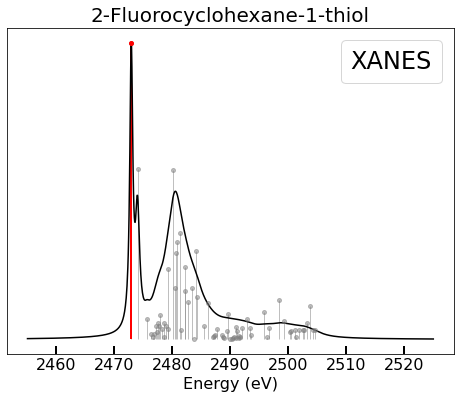

In [13]:
name = '2-Fluorocyclohexane-1-thiol'
index = TEST_NAMES.index(name)

trans1 = TESTData[index]['Transitions']
x1 = TEST_XANES[index]

trans_cut1 = adjust_trans(trans1, x1)
emp = np.zeros(len(trans_cut1[0]), dtype=bool)
emp[-1] = 1

plot_spectrum_and_trans(trans_cut1, [XANESenergy, x1], f'{name}', figsize=(8,6),
                        label='XANES', ylab=False, emp=emp)

In [12]:
# name = 'Thiophenol'#'Methionine_sulfoxide'#'Dibenzothiophene'#'Cysteine'
# index = NAMES.index(name)

# x2 = get_Spectrum(Data, name, mode='XANES')[1]/SCALING_FACTOR
# trans2 = Data[index]['Transitions']

# trans_cut2 = adjust_trans(trans2, x2)

# plot_spectrum_and_trans(trans_cut2, [XANESenergy, x2],
#                         f'{name}', figsize=(8,6),
#                         label='XANES', ylab=True)

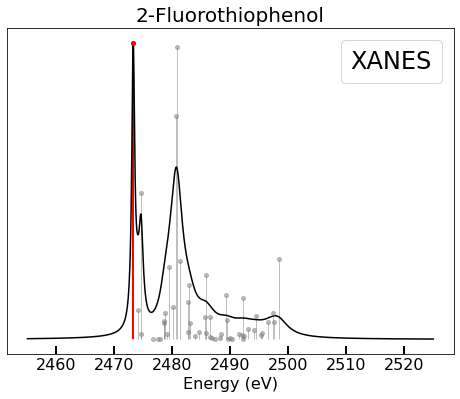

In [14]:
name = '2-Fluorothiophenol'
index = NAMES.index(name)

x2 = get_Spectrum(Data, name, mode='XANES')[1]/SCALING_FACTOR
trans2 = Data[index]['Transitions']

trans_cut2 = adjust_trans(trans2, x2)
emp = np.zeros(len(trans_cut2[0]), dtype=bool)
emp[-1] = 1
# emp[-4] = 1

plot_spectrum_and_trans(trans_cut2, [XANESenergy, x2],
                        f'{name}', figsize=(8,6),
                        label='XANES', ylab=False, emp=emp)

In [14]:
# mn, mx = 130, -230
# in1 = [x1[mn:mx], trans_cut1]
# in2 = [x2[mn:mx], trans_cut2]
# names = ['2-Fluorocyclohexane-1-thiol', '2-Fluorothiophenol']
# stacked_trans(XANESenergy[mn:mx], in1, in2, names, method='XANES')

In [15]:
def rebin(target_peak_energy, XANESenergy, x, max_E=-1):
    
    n = len(XANESenergy)
    x_new = np.zeros(n)
    
    if max_E != -1:
        max_i = index_from_array(XANESenergy, max_E)
    else:
        max_i = -1
    
    peak_index = np.argmax(x[:max_i])   
    target_peak_index = index_from_array(XANESenergy, target_peak_energy)
    
    shift = peak_index - target_peak_index
    
    if shift > 0:
        for i in range(shift, len(XANESenergy)):
            x_new[i - shift] = x[i]
    else:       
        shift = np.abs(shift)
        for i in range(len(XANESenergy) - shift):
            x_new[i + shift] = x[i]
    
    return x_new

In [16]:
def get_x(name):
    x = get_Spectrum(Data, name, mode='XANES')[1]
    x = x/SCALING_FACTOR
    return x

In [17]:
def Spagetti_plot(Data, X=X):
    
    MIN, MAX = 100,830
    
    fig, ax = plt.subplots(figsize=(8,18))
    base = 1
    
    i = 0 
    maxi = np.argmin((XANESenergy-2471.5)**2)
    
    for ele in Data:
        t = ele["Type"]
        y = X[i]
        
        if t == 1:
            y = y*1.4
        if t == 2:
            y = y*2
        if t == 3:
            y = y*1.6
        
        if ele["Type"] == 5:
            y = y*0.8
            if i%3 == 0:
                plt.plot(XANESenergy[MIN:MAX], y[MIN:MAX] + t-1, '-', c=COLORS[t-1], alpha=0.1)
        else:
            plt.plot(XANESenergy[MIN:MAX], y[MIN:MAX] + t-1, '-', c=COLORS[t-1], alpha=0.1)
            
        if ele["Type"] == 1:
            if XANESenergy[np.argmax(y)] < 2472:
                print(f"low energy peak: {ele['name']}")
            if np.max(y) < 0.1:
                print(f"low intensity spectra: {ele['name']}")
                plt.plot(XANESenergy[MIN:MAX], y[MIN:MAX] + np.sum(Peaks[:t-1])*1.25, '-', c='r')
            
        
        i += 1
      
    plt.plot([2470],[4.8],'wo')
                      
    plt.title(f"XANES Spectra", fontsize=30)
    plt.xlabel('Energy (eV)', fontsize=26)
    plt.xticks([2470,2480,2490,2500,2510], [2470,'',2490,'',2510], fontsize=26)
    plt.yticks([],fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)

    plt.show()

low energy peak: gamma-Thiobutyrolactone


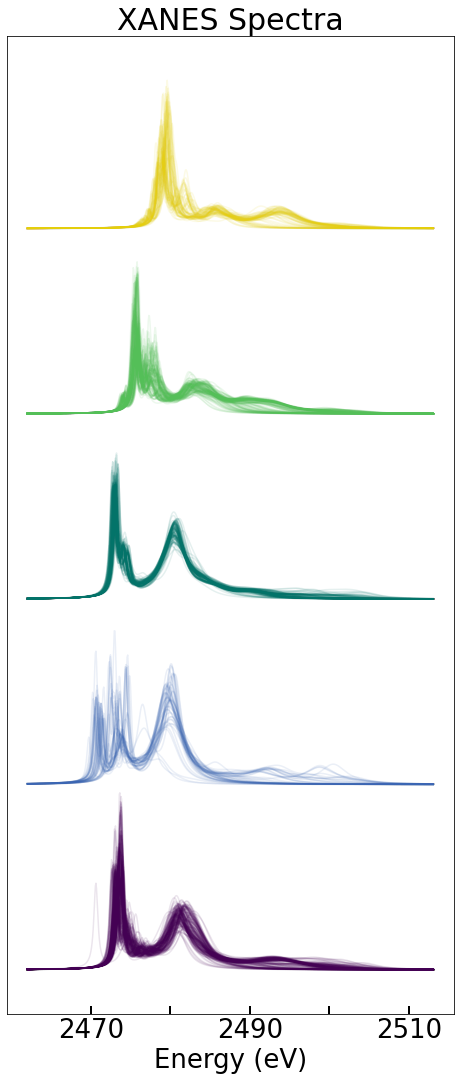

In [18]:
Spagetti_plot(Data, X=X)

In [19]:
# # ------------------------------------------------------------
# # ALIGNING WHITIELINES!
# # ------------------------------------------------------------
# temp_X = X.copy()
    
# for i in range(len(X)):
#     if Data[i]["Type"] == 2:
#         temp_X[i,:] = rebin(2475, XANESenergy, X[i,:], max_E = 2472)
#     else:
#         temp_X[i,:] = rebin(2475, XANESenergy, X[i,:])

# Spagetti_plot(Data, X=temp_X)
# X = temp_X.copy()

In [20]:
# names = ['Methionine', 'Cysteine']
# Spectra = [get_x(name) for name in names]
# stack_plot(XANESenergy, Spectra, names, '', space=0, figsize=(12,8), leg=1)

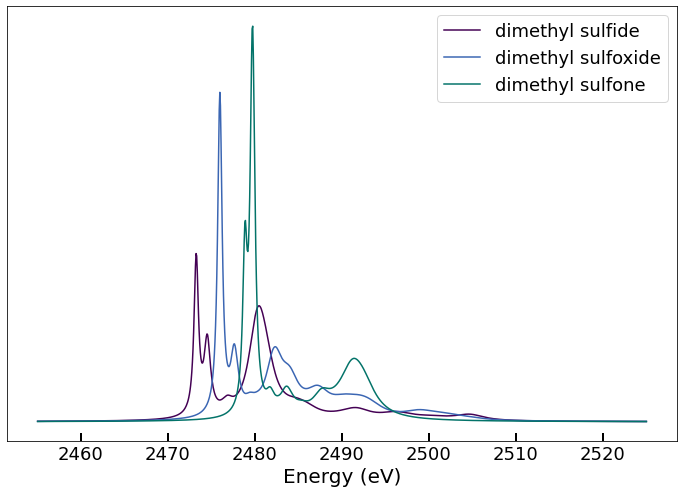

In [21]:
# names = ['Allyl_Sulfide-sulfone','Allyl_sulfoxide', 'Allyl_Sulfide']
names = ['Dimethyl_Sulfide', 'Dimethyl_Sulfoxide', 'Dimethyl_sulfone']
Spectra = [get_x(name) for name in names]
# names = ['Allyl Sulfone','Allyl Sulfoxide','Allyl Sulfide']
names = ['dimethyl sulfide', 'dimethyl sulfoxide', 'dimethyl sulfone']
stack_plot(XANESenergy, Spectra, names, '', space=0, figsize=(12,8), leg=1)

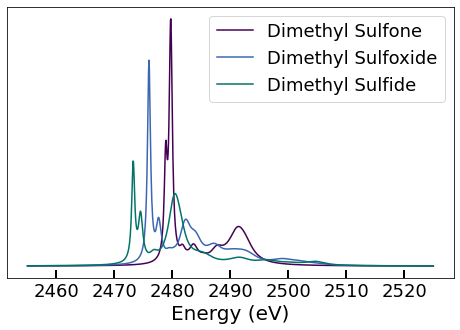

In [22]:
names = ['Dimethyl_sulfone','Dimethyl_Sulfoxide', 'Dimethyl_Sulfide']
Spectra = [get_x(name) for name in names]
names = ['Dimethyl Sulfone','Dimethyl Sulfoxide', 'Dimethyl Sulfide']
stack_plot(XANESenergy, Spectra, names, '', space=0, figsize=(8,5), leg=1)
# XANESenergy[np.argmax(Spectra[0])] - XANESenergy[np.argmax(Spectra[1])]

In [23]:
# sub_Spagetti(Data)

=========================================================================================================================

# Data analysis

# Artificial Neural Network Section

### Network hyperparameters

In [24]:
# hidden layer dimensions
intermediate_dim_1 = 1024#512

batch_size = 50
epochs = 120

train_size = 700

### Generating Labels

In [25]:
# PROPERTY = 'Type'
# PROPERTY = 'oxy'
PROPERTY = 'category'

In [26]:
Y = get_Property(Data, PROPERTY) #labels are one hot encoded

## Data pre-processing and shuffling

In [27]:
# random shuffle of data
Xshuffle, Yshuffle = shuffle_xy(X, Y)

#### Dividing data into training set, validation set, and test set

In [28]:
x_train = Xshuffle[:train_size]
y_train = Yshuffle[:train_size]

x_test = Xshuffle[train_size:]
y_test = Yshuffle[train_size:]

n_y = y_train.shape[1]
n_x = x_train.shape[1]

# Generating ANN Model

In [29]:
# input
Xin = Input(shape=(n_x,), name='spectra_input')
# model layers
lay = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2',
            name='hidden_layer_1')(Xin)
lay = Dropout(0.05)(lay)
# lay = Dense(intermediate_dim_2, activation='relu', name='layer_2')(lay)
nn_out = Dense(n_y, activation='softmax', name='classifier')(lay)

ANN = Model(Xin, nn_out)

ANN.compile(optimizer='adam', loss='binary_crossentropy')
ANN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectra_input (InputLayer)   [(None, 1000)]            0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 1024)              1025024   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
classifier (Dense)           (None, 10)                10250     
Total params: 1,035,274
Trainable params: 1,035,274
Non-trainable params: 0
_________________________________________________________________


### Training

In [30]:
# ANN.fit(x_train, y_train, 
#          shuffle=True, batch_size=batch_size, epochs=epochs,
#          validation_data=(x_test, y_test))
# ANN.save(f'models/XANES_ANN_{PROPERTY}.h5')

In [31]:
PROPERTY = 'Type'
# PROPERTY = 'oxy'
# PROPERTY = 'category'
ANN = load_model(f'models/XANES_ANN_{PROPERTY}.h5', compile=False)

# Prediction Results

In [32]:
if PROPERTY == 'oxy':
    one_hot_encoded_label = np.zeros((len(TEST_XANES), 3))
    for i,o in enumerate(TEST_OXY):
        one_hot_encoded_label[i,o-1] = 1
    true, pred = get_prediction(ANN, TEST_XANES, one_hot_encoded_label)
if PROPERTY == 'Type':
    one_hot_encoded_label = np.zeros((len(TEST_XANES), 5))
    for i,t in enumerate(TEST_TYPE):
        one_hot_encoded_label[i,t-1] = 1
    true, pred = get_prediction(ANN, TEST_XANES, one_hot_encoded_label)
if PROPERTY == 'category':
    one_hot_encoded_label = np.zeros((len(TEST_XANES), 10))
    for i,t in enumerate(TEST_CAT):
        one_hot_encoded_label[i,t-1] = 1
    true, pred = get_prediction(ANN, TEST_XANES, one_hot_encoded_label)

In [33]:
totalTestAccuracy = sum(1 for i in range(len(pred)) if pred[i] == true[i])/len(pred)
print(f"Total accuracy on test data: {totalTestAccuracy} of {len(pred)} compounds")

Total accuracy on test data: 0.8461538461538461 of 52 compounds


### Confusion Matrix

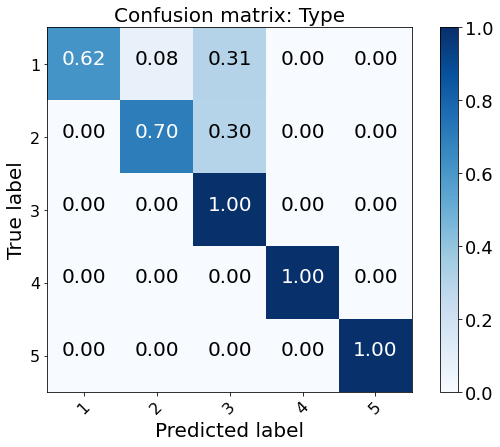

In [34]:
if PROPERTY == 'Type':    
    make_confusion_matrix(true, pred, Types, PROPERTY)
if PROPERTY == 'oxy':
    make_confusion_matrix(true, pred, Oxys, PROPERTY)
if PROPERTY == 'category':
    make_confusion_matrix(true, pred, Categories, PROPERTY)

=========================================================================================================================

# VAE Categorization

In [35]:
# hidden layer dimensions
intermediate_dim_1 = 512
intermediate_dim_2 = 246
latent_dim = 2

batch_size = 50
epochs = 120

dropout = 0.15 #0.2

activation='relu'

In [36]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [37]:
# # input
# Xin = Input(shape=(n_x,), name='spectra_input')

# #activity_regularizer=l2(l2_rate)

# # encoder
# x = Dense(intermediate_dim_1, activation=activation, kernel_regularizer='l2')(Xin)
# x = Dropout(dropout)(x)
# x = Dense(intermediate_dim_2, activation=activation, kernel_regularizer='l2')(x)
# x = Dropout(dropout)(x)
# z_mean = Dense(latent_dim, name='z_mean')(x)
# z_log_var = Dense(latent_dim, name='z_log_var')(x)

# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# # z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# z = Sampling()([z_mean, z_log_var])

# # encoder
# encoder = Model(Xin, [z_mean, z_log_var, z], name='encoder')

# # decoder
# latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(intermediate_dim_1, activation=activation, kernel_regularizer='l2')(latent_inputs)
# x = Dropout(dropout)(x)
# x = Dense(intermediate_dim_1, activation=activation, kernel_regularizer='l2')(x)
# x = Dropout(dropout)(x)
# outputs = Dense(n_x, activation='sigmoid')(x)

# decoder = Model(latent_inputs, outputs, name='decoder')

# # VAE
# Output = decoder(encoder(Xin)[2])
# vae = Model(Xin, Output, name='VAE')

# reconstruction_loss = n_x * binary_crossentropy(Xin, Output)
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
# vae_loss = K.mean(reconstruction_loss + kl_loss)

# vae.add_loss(vae_loss)

# vae.compile(optimizer='adam')

# history = vae.fit(x_train,
#         epochs=epochs,
#         batch_size=batch_size,
#         validation_data=(x_test, None))

# # vae.save('models/XANES_VAE', save_format="tf")
# # encoder.save('models/XANES_encoder', save_format="tf")
# # decoder.save('models/XANES_decoder', save_format="tf")

In [38]:
# vae.save('models/XANES_VAE', save_format="tf")
# encoder.save('models/XANES_encoder', save_format="tf")
# decoder.save('models/XANES_decoder', save_format="tf")

In [39]:
vae = load_model('models/XANES_VAE', compile=False)
encoder = load_model('models/XANES_encoder', compile=False)
decoder = load_model('models/XANES_decoder', compile=False)
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spectra_input (InputLayer)      [(None, 1000)]       0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 639698      spectra_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 1000)         777192      encoder[0][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          512512      spectra_input[0][0]              
                                                                 spectra_input[0][0]            

In [40]:
# copy pasted from XESML
# xes_loss = np.array([587.4163208007812, 289.7535095214844, 235.5487518310547, 219.5084686279297, 212.82444763183594, 209.2156219482422, 206.50743103027344, 205.59414672851562, 203.83714294433594, 202.40573120117188, 201.30972290039062, 200.91807556152344, 200.20797729492188, 198.9169464111328, 198.54226684570312, 197.57217407226562, 196.9044647216797, 196.51730346679688, 196.10800170898438, 195.96981811523438, 195.58645629882812, 195.17782592773438, 194.9303741455078, 194.8458251953125, 194.57009887695312, 194.4072723388672, 194.02676391601562, 193.9930419921875, 193.73245239257812, 193.5954132080078, 193.58607482910156, 193.28297424316406, 193.13406372070312, 192.95486450195312, 192.94143676757812, 192.711669921875, 192.64797973632812, 192.4241180419922, 192.54666137695312, 192.45594787597656, 192.3738250732422, 192.21609497070312, 192.0460205078125, 192.06813049316406, 191.87437438964844, 191.6284637451172, 191.53512573242188, 191.32748413085938, 191.18458557128906, 190.96182250976562, 190.77999877929688, 190.6433563232422, 190.4116973876953, 190.34751892089844, 190.0126953125, 189.8665771484375, 189.70053100585938, 189.70518493652344, 189.522216796875, 189.39083862304688, 189.296875, 189.22242736816406, 189.1047821044922, 189.0765380859375, 189.00808715820312, 189.04383850097656, 188.93336486816406, 189.00196838378906, 188.86767578125, 188.87838745117188, 188.86474609375, 188.677978515625, 188.83889770507812, 188.8516845703125, 188.75643920898438, 188.76602172851562, 188.57406616210938, 188.64712524414062, 188.70254516601562, 188.6536865234375, 188.68826293945312, 188.71859741210938, 188.72817993164062, 188.68235778808594, 188.6370391845703, 188.59071350097656, 188.51248168945312, 188.56654357910156, 188.60508728027344, 188.49110412597656, 188.40243530273438, 188.39938354492188, 188.45364379882812, 188.47984313964844, 188.5147247314453, 188.462646484375, 188.4756622314453, 188.45631408691406, 188.4014892578125, 188.51417541503906, 188.3063201904297, 188.3390655517578, 188.34658813476562, 188.384765625, 188.46426391601562, 188.37205505371094, 188.35264587402344, 188.2953338623047, 188.3475799560547, 188.3788604736328, 188.34207153320312, 188.2994842529297, 188.3293914794922, 188.30763244628906, 188.33200073242188, 188.2676544189453, 188.20565795898438, 188.30099487304688, 188.3021240234375, 188.3164825439453])
# xes_val_loss = np.array([346.8323059082031, 246.225341796875, 224.42642211914062, 215.96360778808594, 211.27345275878906, 208.4990692138672, 206.29312133789062, 204.4748077392578, 204.44627380371094, 203.5107879638672, 201.87852478027344, 202.4175262451172, 202.30313110351562, 200.8977508544922, 199.2266082763672, 198.39215087890625, 197.66590881347656, 197.93704223632812, 198.3144989013672, 197.57135009765625, 196.82815551757812, 197.28977966308594, 196.3883056640625, 196.32765197753906, 195.81593322753906, 196.8367156982422, 195.54415893554688, 195.62374877929688, 195.3625030517578, 196.1329803466797, 194.63760375976562, 195.19976806640625, 195.12294006347656, 194.79791259765625, 194.91551208496094, 194.45570373535156, 194.64332580566406, 194.26771545410156, 194.2083740234375, 194.47360229492188, 194.08761596679688, 193.97515869140625, 194.1699981689453, 193.87933349609375, 194.17970275878906, 193.85716247558594, 193.21180725097656, 193.21832275390625, 193.2945556640625, 193.23414611816406, 192.95335388183594, 193.10400390625, 192.85543823242188, 192.3883819580078, 192.2591552734375, 191.67233276367188, 192.2103271484375, 191.4141845703125, 191.30606079101562, 191.69781494140625, 191.07762145996094, 191.08543395996094, 190.86289978027344, 191.19139099121094, 191.12693786621094, 191.41961669921875, 190.85488891601562, 190.6076202392578, 191.1174774169922, 190.9752197265625, 190.82057189941406, 190.3340606689453, 190.41099548339844, 190.62205505371094, 191.0916748046875, 191.08103942871094, 191.06820678710938, 191.1313934326172, 190.4407958984375, 191.11041259765625, 190.34962463378906, 190.5491180419922, 190.9296417236328, 190.93478393554688, 190.72142028808594, 190.34625244140625, 191.04705810546875, 190.51583862304688, 190.69326782226562, 190.4501953125, 190.8927764892578, 190.2116241455078, 190.27056884765625, 190.06187438964844, 190.7169189453125, 190.17642211914062, 190.8031768798828, 190.86965942382812, 191.1562042236328, 190.30752563476562, 190.2003936767578, 190.61492919921875, 190.2936553955078, 190.61207580566406, 190.18008422851562, 190.37867736816406, 190.09913635253906, 190.2353973388672, 190.40492248535156, 190.10885620117188, 191.0023193359375, 190.5455780029297, 190.69032287597656, 190.1829376220703, 190.71221923828125, 190.41909790039062, 190.44664001464844, 190.3867950439453, 190.63941955566406, 190.24461364746094])

In [41]:
# show_loss(history, 'XANES')
# show_combined_loss(history, [xes_loss, xes_val_loss])

In [42]:
def plot(PROPERTY, x_predict, y_predict, encoder, X, normalize=False, test_index=None,
         extra_name=None, save=False, focus=None, a=.3, s=5, leg=3, black=False):
     
    z_mean = encoder.predict(x_predict, batch_size=1)[0]
    
    if normalize:
        z_mean = normalize_z_mean(z_mean)
    
    fontsize=28
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
#     fig, ax = plt.subplots(figsize=(12, 8))
    
    cbar_vis = True
    
    if PROPERTY == 'oxy':
        Colors = [COLORS[0], COLORS[2], COLORS[4]]
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict)*2-4, cmap=cmap)
        ticks = Oxys
        title = 'Oxidation'
        loc = [-1.33, 0, 1.33]
        label = title
        
    elif PROPERTY == 'category':
        Colors = list(COLORMAP(np.arange(1,11)/9))
        title = "Category"
        label = title
        
        if focus is not None:
            
            for i in range(10):
                Colors[i] = (128/255,128/255,128/255,0.2)
            
            # type 1
            Colors[0] = COLORS[0].copy()
            Colors[1] = '#9F5F80'
            # type 2
            Colors[2] = '#03506F'
            Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
            # type 3
            Colors[4] = '#DB6400' #'#ac3501'
            Colors[5] = '#ffba93' #'#f89345'
            # type 4
            Colors[6] = '#2b3016'
            Colors[7] = COLORS[3].copy()
            # type 5
            Colors[8] = '#ac3501'
            Colors[9] = COLORS[4]
            
            title = 'Conjugated vs Not Conjugated'
            
            t1a = mpatches.Patch(color=Colors[0], label='Type 1 Ali.')
            t1b = mpatches.Patch(color=Colors[1], label='Type 1 Aro.')
            t2a = mpatches.Patch(color=Colors[2], label='Type 2 Ali.')
            t2b = mpatches.Patch(color=Colors[3], label='Type 2 Aro.')
            t3a = mpatches.Patch(color=Colors[4], label='Type 3 Ali.')
            t3b = mpatches.Patch(color=Colors[5], label='Type 3 Aro.')
            t4a = mpatches.Patch(color=Colors[6], label='Type 4 Ali.')
            t4b = mpatches.Patch(color=Colors[7], label='Type 4 Aro.')
            t5a = mpatches.Patch(color=Colors[8], label='Type 5 Ali.')
            t5b = mpatches.Patch(color=Colors[9], label='Type 5 Aro.')
            space = mpatches.Patch(color='w', label='')
            
            fig.subplots_adjust(right=0.75)
            
#             plt.legend(handles=[t1a, t1b, space, t2a, t2b, space, t3a, t3b, space, t4a, t4b, space, t5a, t5b],
#                     fontsize=14, bbox_to_anchor=(1.02, 0.97), loc=leg, borderaxespad=0.)

            cbar_vis = False
            
        
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
        
        if cbar_vis:
            cbar = plt.colorbar(ticks=np.arange(10)+1)
        
    elif PROPERTY == 'Type':
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
        ticks = Types
        title = "Type"
        label = title
        loc = [1.4, 2.2, 3, 3.8, 4.6]
        if test_index is not None:
            ztest = encoder.predict(TEST_XANES)[0]
            if test_index is 'all':
                plt.scatter(ztest[:, 0], ztest[:, 1], c='r', s=35)
            else:
                plt.plot(ztest[test_index, 0], ztest[test_index, 1], 'r.', markersize=15)
        
    else:
        
        z_meanX = encoder.predict(X, batch_size=batch_size)[0]
        Y = one_hot_to_num(get_Property(Data, 'oxy'))
        
        Colors = [COLORS[0], COLORS[2], COLORS[4]]
        cmap = ListedColormap(Colors)
        plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c=Y*2-4, cmap=cmap)
        if z_mean.shape[0] > 5:
            alpha, color, ms = a, 'k', s
            plt.plot(z_mean[:, 0], z_mean[:, 1], '.-', c=color, alpha=alpha, markersize=ms)
        else:
            alpha, color, ms = a, 'r', s
            plt.plot(z_mean[:, 0], z_mean[:, 1], '.', c=color, alpha=alpha, markersize=ms)
            extra_name = None
        title = PROPERTY
        label = 'Oxidation'
        ticks = Oxys
        loc = [-1.33, 0, 1.33]
        if extra_name is not None:
            x = np.array([get_x(extra_name)])
            extra_name = extra_name.lower().replace('_' , ' ')
            z_loc = encoder.predict(x, batch_size=1)[0]
            plt.plot(z_loc[:, 0], z_loc[:, 1], '.', c='r', alpha=1., markersize=15, label=extra_name)
            plt.legend(fontsize=20)
    
    if black:
        z_meanX = encoder.predict(X, batch_size=batch_size)[0]
        Y = one_hot_to_num(get_Property(Data, 'oxy'))
        plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c='k')
        cbar_vis=False
    
    if cbar_vis:
        cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
        cbar = plt.colorbar(cax=cbaxes, ticks=ticks)
        cbar.set_label(label, fontsize=26)
        cbar.set_ticks(loc)
        cbar.ax.tick_params(labelsize=26)
        cbar.set_ticklabels(ticks)
        if extra_name is None:
            legend = ax.legend(['VAE'], handlelength=0, handletextpad=0, fancybox=True, fontsize=fontsize+12)
            for item in legend.legendHandles:
                item.set_visible(False)
    
    plt.xticks(fontsize=fontsize+3)
    plt.yticks(fontsize=fontsize+3)
    
#     plt.title(f"Latent Space: {title}", fontsize=fontsize+8)
    ax.set_xlabel(f"z [0]", fontsize=fontsize+6)
    ax.set_ylabel(f"z [1]", fontsize=fontsize+6)
    ax.tick_params(direction='in', width=2, length=8)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()
    if save:
        fig.savefig(f'{title}.png', bbox='tight')

In [43]:
def find_most_similar(Data, spectra):
    min_error = np.Infinity
    name, most_similar = None, None
    for ele in Data:
        ref = ele['XANES'][1,:]
        ref = ref/np.max(ref)
        err = np.sqrt(np.sum((ref - spectra)**2))
        if err < min_error:
            min_error = err
            most_similar = ref
            name = ele['name']
    return name, most_similar

In [44]:
Is = [0, 200, 300, 450, 700]
x_decode = np.array([X[i] for i in Is])
decode_names = np.array([NAMES[i] for i in Is])
print(decode_names)

['1,3-Thiazol-4-ylacetic_acid' 'Protionamide' '4-dimethylamino-thiophenol'
 'Dl-Ethionine_sulfoxide' 'Tetrachlorothiophene-sulfone']


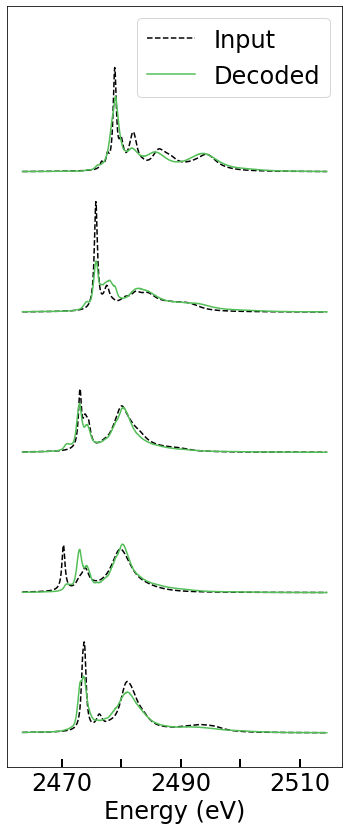

In [45]:
plot_in_v_out(XANESenergy, vae, x_decode, decode_names, figsize=(6,14), c=3, x_range=(120,-150), method='XANES')

In [46]:
PROPERTIES = ['oxy', 'Type', 'category']
Labels = []
for PROPERTY in PROPERTIES:
    Labels.append(get_Property(Data, PROPERTY))

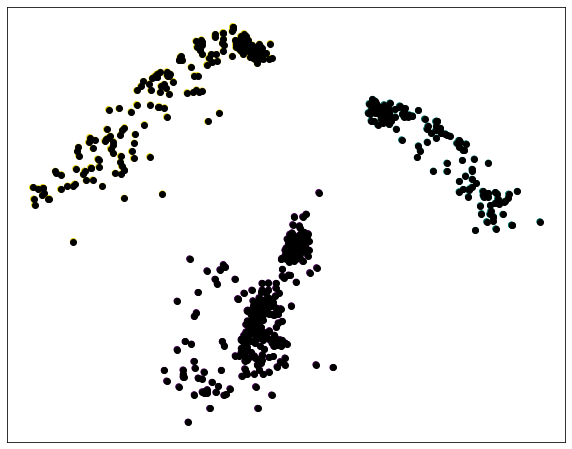

In [47]:
plot(PROPERTIES[0], X, Labels[0], encoder, X, black=True)

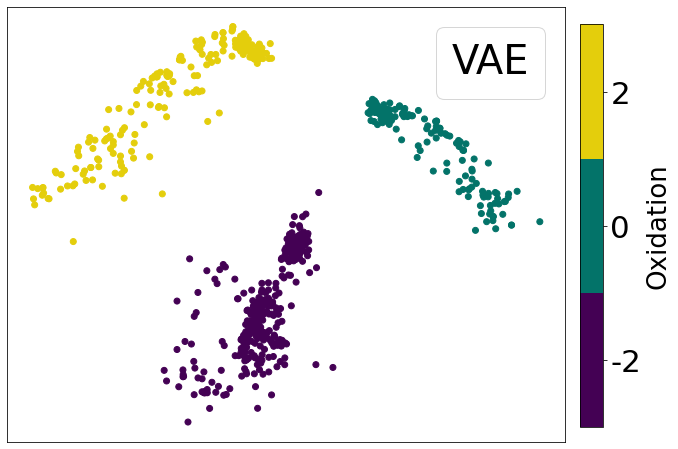

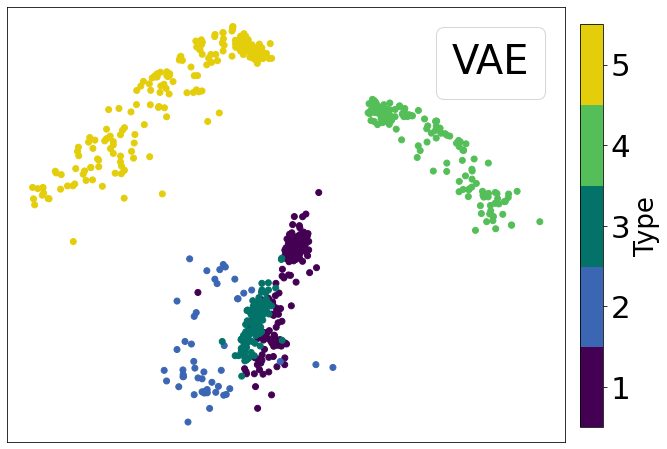

In [48]:
for PROPERTY in PROPERTIES[:2]:
    if latent_dim is 2:
        plot(PROPERTY, X, Labels[PROPERTIES.index(PROPERTY)], encoder, X)

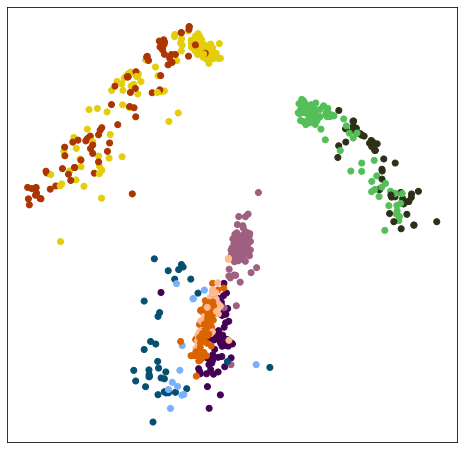

In [49]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot('category', X, Labels[2], encoder, X, focus=1, leg=2)

In [50]:
def get_type_eles(Data, t):
    temp = []
    for ele in Data:
        if ele['Type'] == t:
            temp.append(ele)
    return temp

In [51]:
def network_plot(title, x_predict_list, encoder):
    
    z_means = []
    for x in x_predict_list:
        z_mean = encoder.predict(x, batch_size=100)[0]
        z_means.append(z_mean)
    
    z_meanX = encoder.predict(X, batch_size=batch_size)[0]
    Y = one_hot_to_num(get_Property(Data, 'oxy'))
    
    fontsize=22
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
        
    Colors = [COLORS[0], COLORS[2], COLORS[4]]
    cmap = ListedColormap(Colors)
    plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c=Y*2-4, cmap=cmap)
    
    alpha, color, ms = 0.01, 'k', 2
    
    for z_mean in z_means:
        plt.plot(z_mean[:, 0], z_mean[:, 1], '-', c=color, alpha=alpha, markersize=ms)

    loc = [-1.33, 0, 1.33]
    cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
    cbar = plt.colorbar(cax=cbaxes, ticks=Oxys)
    cbar.set_label('Oxidation', fontsize=26)
    cbar.set_ticks(loc)
    cbar.ax.tick_params(labelsize=22)
    cbar.set_ticklabels(Oxys)    
    legend = ax.legend(['VAE'], handlelength=0, handletextpad=0, fancybox=True, fontsize=fontsize+8)
    for item in legend.legendHandles:
        item.set_visible(False)
    
    plt.xticks(fontsize=fontsize+3)
    plt.yticks(fontsize=fontsize+3)
    
    ax.set_xlabel(f"z [0]", fontsize=fontsize+6)
    ax.set_ylabel(f"z [1]", fontsize=fontsize+6)
    ax.tick_params(direction='in', width=2, length=8)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

In [52]:
def make_network_plot():
    X_Types = []
    for t in Types:
        names = get_Property(get_type_eles(Data, t), 'name')
        X_temp = []
        for name in names:
            X_temp.append(get_x(name))
        random.shuffle(X_temp)
        X_Types.append(X_temp)

    percents = np.linspace(0,1,6)

    x_list = []

    sample_size = [20, 10, 20, 20, 20]

    random_start = np.zeros(5)
    for i in Types:
        max_ind = len(X_Types[i-1]) - sample_size[i-1] - 1
        random_start[i-1] = randint(0, max_ind)    
    # print(random_start)

    for i in range(5):
        start_i = int(random_start[i])
        sample_i = sample_size[i]
        for x1 in X_Types[i][start_i : start_i + sample_i]:
            j = i + 1
            if i == j:
                break
            while j < 5:
                start_j = int(random_start[j])
                sample_j = sample_size[j]
                for x2 in X_Types[j][start_j : start_j + sample_j]:
                    x_list.append(np.array([x1*percent + x2*(1-percent) for percent in percents]))
                j += 1

    print(f'Total combinations: {len(x_list)}')       
    network_plot("Network Plot", x_list, encoder)

In [53]:
# make_network_plot()

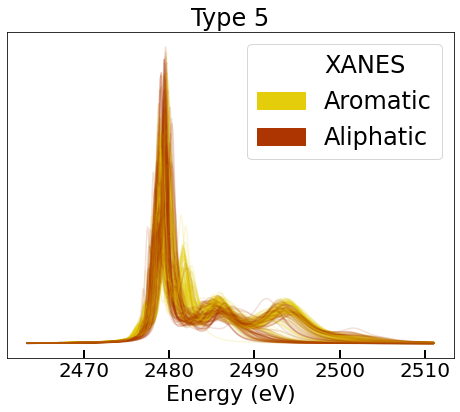

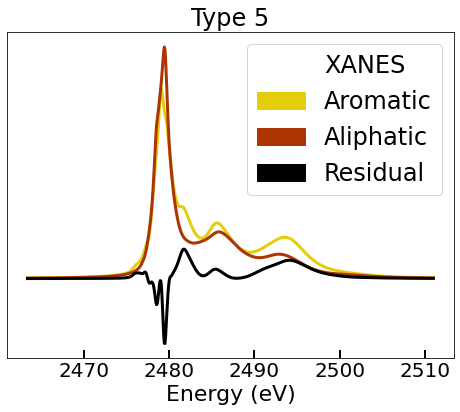

In [54]:
type_spagetti(XANESenergy, NAMES, Data, 'XANES', X, Type=5, space=0., figsize=(8,6), alpha=0.15) 

In [55]:
# 5-Chloro-2-thiophenecarbonitrile_oxide needs to be run with ECP again

In [56]:
# between non conjugated compounds:
# Type 1 peak: 2473.0682244744744 +/- 0.40704529126172256
# Type 3 peak: 2472.937937937938 +/- 0.14014014014006662

### K means

In [57]:
def plot_centroids(x_predict, y_predict, codebook):
    
    z_mean = encoder.predict(x_predict, batch_size=batch_size)[0]
    
    fontsize=16
    fig, ax = plt.subplots(figsize=(12, 8))
    if PROPERTY == 'oxy':
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict)*2-4, cmap=COLORMAP)
        plt.colorbar(ticks=Oxys)
        plt.title("Latent Space vs Sulfur Oxidation", fontsize=fontsize+4)
    elif PROPERTY == 'category':
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=COLORMAP)
        plt.colorbar()
        plt.title("Latent Space vs Category", fontsize=fontsize+4)
    else:
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
        cbar = plt.colorbar(ticks=Types)
#         plt.title("Latent Space vs Type", fontsize=fontsize+4)
    
    plt.plot(codebook[:, 0], codebook[:, 1], '.', c='r', markersize=20)
    
    cbar.set_label(PROPERTY, fontsize=26)
    cbar.ax.tick_params(labelsize=22)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

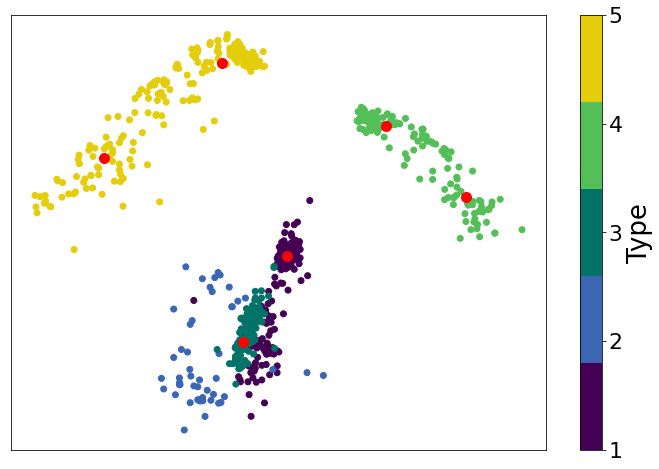

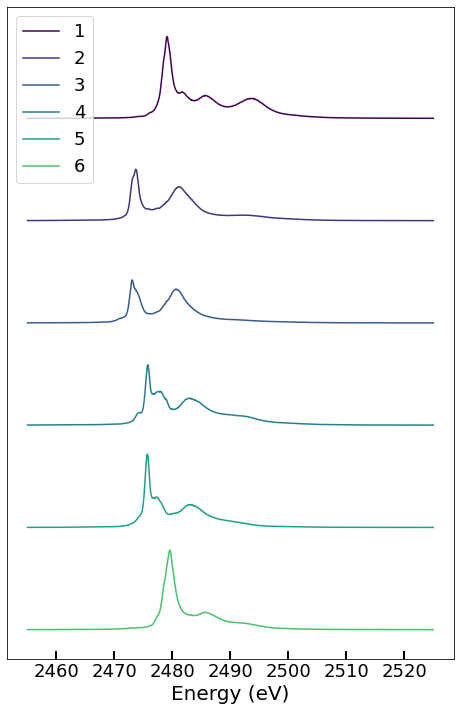

In [58]:
PROPERTY = 'Type'
z_mean = encoder.predict(X)[0]
codebook, distortion = kmeans(z_mean, 6)
plot_centroids(X, Labels[PROPERTIES.index(PROPERTY)], codebook)
Spectra = decoder.predict(codebook)
stack_plot(XANESenergy, Spectra, np.arange(len(codebook))+1, title=f'', space=0.6, figsize=(8,12))

# One Type VAE

In [59]:
# # 'Aliphatic', 'Aromatic'
# myType = 1
# x_one = []
# y_one = []
# for ele in Data:
#     if ele['Type'] in [1,2,3]:
# #     if ele['Type'] == myType:
#         x = ele['XANES'][1]
#         x = x - np.min(x)
#         x = x/np.max(x)
#         x_one.append(x)
#         y = ele['category']
#         y_one.append(y)

# x_one = np.array(x_one)
# y_one = np.array(y_one)

# x_one, y_one = shuffle_xy(x_one, y_one)

In [60]:
# n_x = 1000
# intermediate_dim_1 = 256

# # input
# Xin = Input(shape=(n_x,), name='spectra_input')

# # encoder
# x = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(Xin)
# x = Dropout(0.01)(x)
# z_mean = Dense(latent_dim, name='z_mean')(x)
# z_log_var = Dense(latent_dim, name='z_log_var')(x)

# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# # encoder
# encoder3 = Model(Xin, [z_mean, z_log_var, z], name='encoder')

# # decoder
# latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(latent_inputs)
# x = Dropout(0.01)(x)
# outputs = Dense(n_x, activation='sigmoid')(x)

# decoder = Model(latent_inputs, outputs, name='decoder')

# # VAE
# Output = decoder(encoder3(Xin)[2])
# vae2 = Model(Xin, Output, name='VAE')

# reconstruction_loss = n_x * binary_crossentropy(Xin, Output)
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
# vae_loss = K.mean(reconstruction_loss + kl_loss)

# vae2.add_loss(vae_loss)
# vae2.compile(optimizer='adam')

In [61]:
# training_size = [150, 45, 120, 130, 210]
# type_size = training_size[myType-1]
# type_size = 345
# vae2.fit(x_one[:type_size],
#         epochs=45,
#         batch_size=30,
#         validation_data=(x_one[type_size:], None))

In [62]:
# plot('all', x_one, y_one, encoder3, x_one)

# PCA

In [63]:
def plot_dim_red(PROPERTY, X_red, Y, method, pt=None, leg=2, cbar_vis=True, fontsize=28, show_legend=False):
    
    Colors = list(COLORMAP(np.arange(1,11)/9))
    for i in range(10):
        Colors[i] = (128/255,128/255,128/255,0.2)
            
    # type 1
    Colors[0] = COLORS[0].copy()
    Colors[1] = '#9F5F80'
    # type 2
    Colors[2] = '#03506F'
    Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
    # type 3
    Colors[4] = '#DB6400' #'#ac3501'
    Colors[5] = '#ffba93' #'#f89345'
    # type 4
    Colors[6] = '#2b3016' 
    Colors[7] = COLORS[3].copy()
    # type 5
    Colors[8] = '#ac3501'
    Colors[9] = COLORS[4]

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
#     fig, ax = plt.subplots(figsize=(12, 8))
    
    if PROPERTY == 'oxy':
        Colors = [COLORS[0], COLORS[2], COLORS[4]]
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=one_hot_to_num(Y)*2-4, cmap=cmap)
        ticks=Oxys
        title = 'Oxidation'
        loc = [-1.33, 0, 1.33]
        label = title
        
    elif PROPERTY == 'category':
        
        title = "Category"
        label = title
            
        title = 'Conjugated vs Not Conjugated'
            
        t1a = mpatches.Patch(color=Colors[0], label='Type 1 Ali.')
        t1b = mpatches.Patch(color=Colors[1], label='Type 1 Aro.')
        t2a = mpatches.Patch(color=Colors[2], label='Type 2 Ali.')
        t2b = mpatches.Patch(color=Colors[3], label='Type 2 Aro.')
        t3a = mpatches.Patch(color=Colors[4], label='Type 3 Ali.')
        t3b = mpatches.Patch(color=Colors[5], label='Type 3 Aro.')
        t4a = mpatches.Patch(color=Colors[6], label='Type 4 Ali.')
        t4b = mpatches.Patch(color=Colors[7], label='Type 4 Aro.')
        t5a = mpatches.Patch(color=Colors[8], label='Type 5 Ali.')
        t5b = mpatches.Patch(color=Colors[9], label='Type 5 Aro.')
        space = mpatches.Patch(color='w', label='')
            
        fig.subplots_adjust(right=0.75)
        
        Y = one_hot_to_num(Y)
#         double = ['2-2-Hydroxyphenyl_benzothiazole','2-Benzoylthiophene','Azathioprine','Chlorpromazine',
#                   'Dibenzothiophene','Methylene_blue','Olanzapine','Perphenazine','Phenothiazine',
#                   'Promethazine','Trimeprazine']
#         Colors.append('#BA55D3')
#         for i,y in enumerate(Y):
#             if y == 2 and NAMES[i] in double:
#                 Y[i] = 11
                
#         plt.legend(handles=[t1a, t1b, space, t2a, t2b, space, t3a, t3b, space, t4a, t4b, space, t5a, t5b],
#             fontsize=14, bbox_to_anchor=(1.02, 0.97), loc=leg, borderaxespad=0.)
        

        cbar_vis = False
        
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap)
        
    elif PROPERTY == 'Type':
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=one_hot_to_num(Y), cmap=cmap)
        ticks=Types
        title = "Type"
        loc = [1.4, 2.2, 3, 3.8, 4.6]
        label = title
        
    elif PROPERTY in Types: 
        base = 2*PROPERTY - 2
        subColors = [Colors[base], Colors[base+1]]
        cmap = ListedColormap(subColors)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap)
        ticks=[0,1]
        ticks=['Ali.','Aro.']
        title = f"Type {PROPERTY}"
        loc = [0.25,0.75]
        label = title
    
    if pt is not None:
        plt.scatter(pt[0], pt[1], c='r')
    
    
    if cbar_vis:
        cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
        cbar = plt.colorbar(cax=cbaxes, ticks=ticks)
        cbar.set_label(label, fontsize=26)
        cbar.set_ticks(loc)
        cbar.ax.tick_params(labelsize=22)
        cbar.set_ticklabels(ticks)
        legend = ax.legend([method], handlelength=0, handletextpad=0, fancybox=True, fontsize=fontsize+12)
        for item in legend.legendHandles:
            item.set_visible(False)
    
    plt.xticks(fontsize=fontsize+3)
    plt.yticks(fontsize=fontsize+3)
    
#     plt.title(f"{method}", fontsize=fontsize+12)
    ax.set_xlabel(f"{method} [0]", fontsize=fontsize+6)
    ax.set_ylabel(f"{method} [1]", fontsize=fontsize+6)
    ax.tick_params(direction='in', width=2, length=8)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

#     plt.ylim(0,30)
#     plt.xlim(-15,30)
    
    plt.show()

In [64]:
pca = PCA(n_components=latent_dim)
pca.fit(X)
X_PCA = pca.transform(X)
X_PCA.shape

(717, 2)

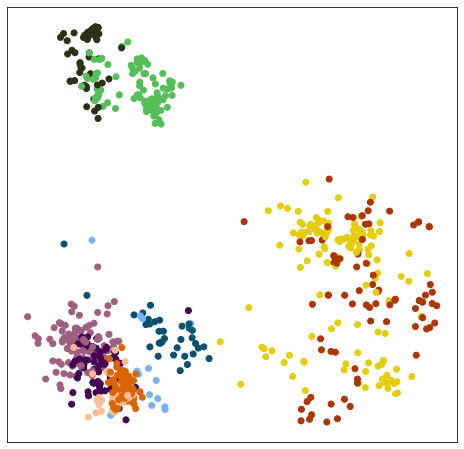

In [65]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red('category', X_PCA, Labels[2],'PCA')

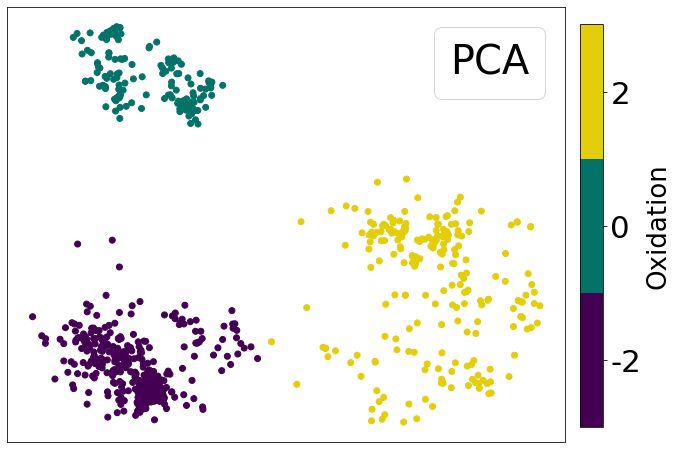

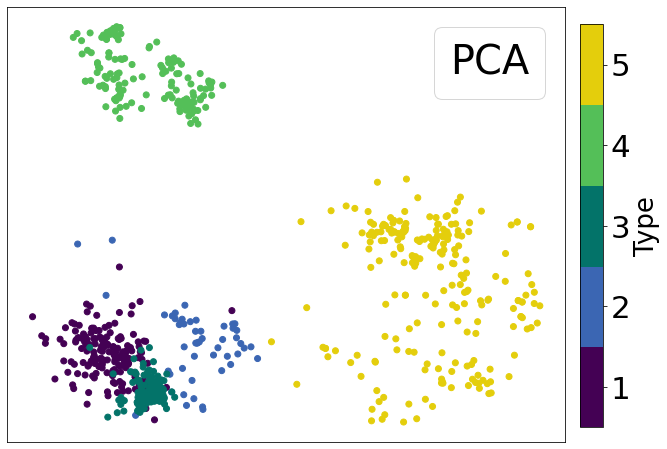

C:\Users\saman\Downloads\Anaconda\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


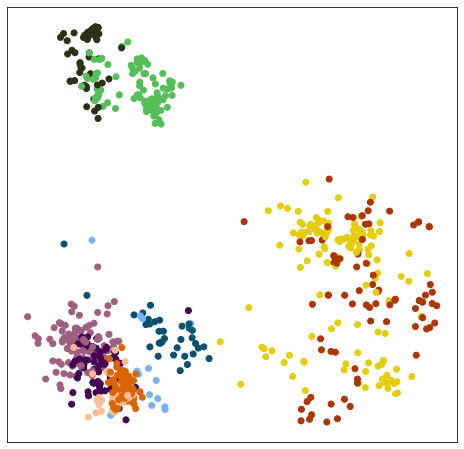

In [66]:
for PROPERTY in PROPERTIES:
    plot_dim_red(PROPERTY, X_PCA, Labels[PROPERTIES.index(PROPERTY)],'PCA')

In [67]:
def make_scree(evals, n):

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(n)+1
    colors = plt.cm.viridis(np.arange(N)/N)

    avg = np.zeros(n)
    for i in range(N):
        y = evals[i]
        y = y/np.sum(y)
#         if i%100 is 0:
#             ax.plot(x, y, markersize=1, color=colors[i])
        avg += y
    
    avg = avg/N
    ax.plot(x, avg, markersize=1, color='k', label='Average')

    plt.title("Scree Plot: XANES", fontsize=20)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Principal Component', fontsize=16)
    plt.ylabel(f'Propertion of Variance Explained', fontsize=16)
    
    plt.legend()

    plt.show()
    
    return avg

In [68]:
n = 30
evals = np.sort(np.abs(X_PCA), axis=1)
evals = np.flip(evals, axis=1)[:,:n]
# xanes_pc = make_scree(evals, n)

In [69]:
xes_pc = np.array(['0.2875087', '0.1646597', '0.1053216', '0.0780890', '0.0601537',
       '0.0466433', '0.0373673', '0.0303080', '0.0250767', '0.0212647',
       '0.0182993', '0.0158733', '0.0139048', '0.0121377', '0.0106921',
       '0.0093613', '0.0082728', '0.0073832', '0.0065962', '0.0059192',
       '0.0053321', '0.0047586', '0.0043150', '0.0039148', '0.0035379',
       '0.0032052', '0.0029080', '0.0026372', '0.0023878', '0.0021706'], dtype=float)

In [70]:
def make_stacked_scree(xes, xanes, n=None):
    
    if n is None:
        n = len(xanes)
    else:
        xes = xes[:n]
        xanes = xanes[:n]

    fig, ax = plt.subplots(figsize=(10, 8))

    x = np.arange(n)+1

    ax.plot(x, xes, 's-', markersize=10, fillstyle='none', color=COLORS[1], label='XES')
    ax.plot(x, xanes, 'o-', markersize=10, color=COLORS[3], label='XANES')
    
#     ax.plot(x, xes, '-', markersize=4, marker='s', color='k', label='XES')
#     ax.plot(x, xanes, 'o-', markersize=4, color=(128/255,128/255,128/255), label='XANES')
    
#     plt.title("Scree Plot", fontsize=20)
    plt.xticks(x, fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('Number of Parameters', fontsize=24)
    plt.ylabel(f'Fraction of Contribution\n(Averaged Over Data)', fontsize=24)
    plt.xlim(0,n+1)
    ax.tick_params(direction='in', width=2, length=8)
    
    plt.legend(fontsize=26)

    plt.show()

In [71]:
# make_stacked_scree(xes_pc, xanes_pc, n=15)

1,3-Thiazol-4-ylacetic_acid


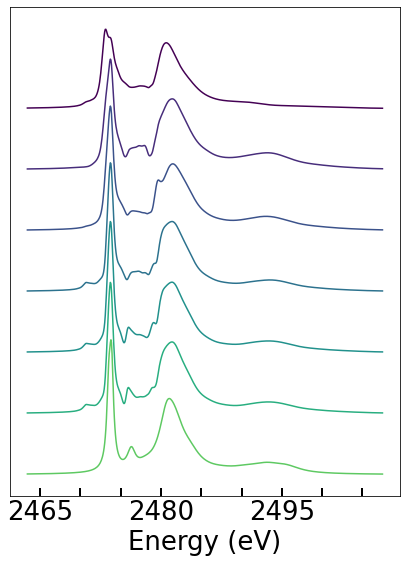

1,3-thiazolidin-2-one-sulfone


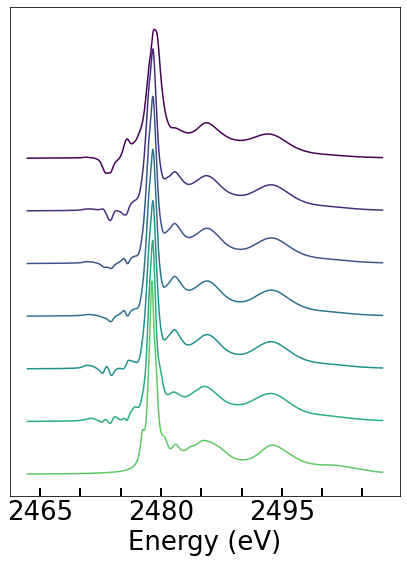

In [88]:
for i in [0, 498]:
    Recon = []
    Names = []

    s, e = 120,-250

    for nc in [2,4,6,8,10,12]:
        pca = PCA(n_components=nc)
        pca.fit(X)
        X_PCA = pca.transform(X)
        recon = pca.inverse_transform(X_PCA)
        Recon.append(recon[i].copy()[s:e])
        Names.append(f"{nc} PCs")

    x = X[i]
    name = Data[i]['name']
    print(name)

    Recon.append(x[s:e])
    Names.append('Target')
    stack_plot(XANESenergy[s:e], Recon, Names, '', space=0.2, figsize=(7,9), fontsize=22, leg=0, ncol=1, method='XANES')

# Other dimension Reduction!!!

In [74]:
# KNN = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(z_mean)
# distances, indices = KNN.kneighbors(z_mean)
# Thank you to:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
#sphx-glr-auto-examples-neighbors-plot-classification-py

def KNN_2D(dim_reducer, train_labels, method, n_neighbors = 40, h = .01, scheme=2, plot=True,
          val=False, normalize=True):

    if val:
        X_train, Y_train = shuffle_xy(X, one_hot_to_num(train_labels))
        train_size = 657
        X_test = X_train[train_size:].copy()
        Y_test = Y_train[train_size:].copy()
        X_train = X_train[:train_size].copy()
        Y_train = Y_train[:train_size].copy()
        
        if method is 'VAE':
            D_train = dim_reducer.predict(X_train, batch_size=20)[0]
            D_test = dim_reducer.predict(X_test, batch_size=20)[0]
        else:
            dim_reducer = dim_reducer.fit(X_train)
            D_train = dim_reducer.transform(X_train)
            D_test = dim_reducer.transform(X_test)
    else:
        X_train, Y_train = shuffle_xy(X, one_hot_to_num(train_labels))
        X_test = TEST_XANES.copy()
        
        if method is 'VAE':
            D_train = dim_reducer.predict(X_train, batch_size=20)[0]
            D_test = dim_reducer.predict(X_test, batch_size=5)[0]
        else:
            dim_reducer = dim_reducer.fit(X_train)
            D_train = dim_reducer.transform(X_train)
            D_test = dim_reducer.transform(X_test)
            
        if scheme == 1:
            Y_test = TEST_OXY
        elif scheme == 2:
            Y_test = TEST_TYPE
        else:
            Y_test = TEST_CAT
    
    fontsize=22
    
    if normalize:
        Std = np.std(D_train, axis=0)
        Mean = np.mean(D_train, axis=0)
        D_train -= Mean
        D_train /= Std
        D_test -= Mean
        D_test /= Std   
    
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(D_train, Y_train)
    
    x_min, x_max = np.min(D_train[:,0]), np.max(D_train[:,0])
    y_min, y_max = np.min(D_train[:,1]), np.max(D_train[:,1])
    
    buffer = np.abs(x_max - x_min)*0.05
    h = (np.abs(x_max - x_min) + 2*buffer) / 100
    
    xx, yy = np.meshgrid(np.arange(x_min-buffer, x_max+buffer, h), np.arange(y_min-buffer, y_max+buffer, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # getting test accuracy
    pred = clf.predict(D_test)
    Accuracy = sum(1 for i in range(len(pred)) if pred[i] == Y_test[i])/len(pred)
    markers = []
    for i in range(len(pred)):
        if pred[i] == Y_test[i]:
            markers.append('o')
        else:
            markers.append('x')

    if plot:
        cbar_vis = True
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
#         fig, ax = plt.subplots(figsize=(12, 8))
        if scheme == 1:
            cmap = ListedColormap([COLORS[0], COLORS[2], COLORS[4]])
            loc = [-1.33, 0, 1.33]
        elif scheme == 2:
            cmap = ListedColormap(COLORS)
        elif scheme == 3:
            Colors = list(COLORMAP(np.arange(1,11)/9))
            # type 1
            Colors[0] = COLORS[0].copy()
            Colors[1] = '#9F5F80'
            # type 2
            Colors[2] = '#03506F'
            Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
            # type 3
            Colors[4] = '#DB6400' 
            Colors[5] = '#ffba93' 
            # type 4
            Colors[6] = '#2b3016' 
            Colors[7] = COLORS[3].copy()
            # type 5
            Colors[8] = '#ac3501'
            Colors[9] = COLORS[4]
            cmap = ListedColormap(Colors)
        
        plt.pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.1)

        if scheme == 1:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train*2-4, cmap=cmap)
            ticks=Oxys
            title = 'Oxidation'       
        elif scheme == 2:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            ticks=Types
            loc = [1.4, 2.2, 3, 3.8, 4.6]
            title = 'Types'
        elif scheme == 3:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            cbar_vis = False
            title = 'Category'

        if cbar_vis:
#             cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
#             cbar= plt.colorbar(cax=cbaxes, ticks=ticks)
            cbar= plt.colorbar(ticks=ticks)
            cbar.set_label(title, fontsize=26)
            cbar.set_ticks(loc)
            cbar.ax.tick_params(labelsize=22)
            cbar.set_ticklabels(ticks)
            black_o = mlines.Line2D([], [], color='k', marker='o', linestyle='None', fillstyle='none',
                              markersize=10, label='Correct')
            black_x = mlines.Line2D([], [], color='k', marker='x', linestyle='None', fillstyle='none',
                              markersize=10, label='Incorrect')
            ax.legend(handles=[black_o, black_x], fontsize=22)
        else:
            t1a = mpatches.Patch(color=Colors[0], label='Type 1 Ali.')
            t1b = mpatches.Patch(color=Colors[1], label='Type 1 Aro.')
            t2a = mpatches.Patch(color=Colors[2], label='Type 2 Ali.')
            t2b = mpatches.Patch(color=Colors[3], label='Type 2 Aro.')
            t3a = mpatches.Patch(color=Colors[4], label='Type 3 Ali.')
            t3b = mpatches.Patch(color=Colors[5], label='Type 3 Aro.')
            t4a = mpatches.Patch(color=Colors[6], label='Type 4 Ali.')
            t4b = mpatches.Patch(color=Colors[7], label='Type 4 Aro.')
            t5a = mpatches.Patch(color=Colors[8], label='Type 5 Ali.')
            t5b = mpatches.Patch(color=Colors[9], label='Type 5 Aro.')
            space = mpatches.Patch(color='w', label='')
            fig.subplots_adjust(right=0.75)
#             plt.legend(handles=[t1a, t1b, space, t2a, t2b, space, t3a, t3b, space, t4a, t4b, space, t5a, t5b],
#                 fontsize=14, bbox_to_anchor=(1.02, 0.97), borderaxespad=0.)
            
        for i in range(len(D_test)):
            plt.plot(D_test[i, 0], D_test[i, 1], marker=markers[i], c='k', markersize=10, fillstyle='none')

        plt.title(f'{method}: {100*Accuracy:.1f}% Accuracy', fontsize=30)
        plt.axis('off')
        plt.ylim(y_min-buffer, y_max+buffer)
        plt.show()
    else:
        if scheme == 1:
            title = 'Oxidation'
        elif scheme == 2:
            title = 'Types'
        else:
            title = 'Category'
        print(f"KNN on {method}: {title} (Accuracy: {Accuracy:.2f})")
        return Accuracy

In [75]:
# KNN = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(z_mean)
# distances, indices = KNN.kneighbors(z_mean)
# Thank you to:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
#sphx-glr-auto-examples-neighbors-plot-classification-py

def KNN_tsne(X_red, train_labels, method, TEST_SIZE, n_neighbors = 40, h = .01, scheme=2, plot=True,
          normalize=True):

    D_train = X_red[:-TEST_SIZE,:]
    Y_train = one_hot_to_num(train_labels)
    
    D_test = X_red[-TEST_SIZE:,:]
        
    if scheme == 1:
        Y_test = TEST_OXY
    elif scheme == 2:
        Y_test = TEST_TYPE
    else:
        Y_test = TEST_CAT
    
    fontsize=22
    
    if normalize:
        Std = np.std(D_train, axis=0)
        Mean = np.mean(D_train, axis=0)
        D_train -= Mean
        D_train /= Std
        D_test -= Mean
        D_test /= Std   
    
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(D_train, Y_train)
    
    x_min, x_max = np.min(D_train[:,0]), np.max(D_train[:,0])
    y_min, y_max = np.min(D_train[:,1]), np.max(D_train[:,1])
    
    buffer = np.abs(x_max - x_min)*0.05
    h = (np.abs(x_max - x_min) + 2*buffer) / 100
    
    xx, yy = np.meshgrid(np.arange(x_min-buffer, x_max+buffer, h), np.arange(y_min-buffer, y_max+buffer, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # getting test accuracy
    pred = clf.predict(D_test)
    Accuracy = sum(1 for i in range(len(pred)) if pred[i] == Y_test[i])/len(pred) 
    markers = []
    for i in range(len(pred)):
        if pred[i] == Y_test[i]:
            markers.append('o')
        else:
            markers.append('x')

    if plot:
        cbar_vis = True
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
#         fig, ax = plt.subplots(figsize=(12, 8))
        if scheme == 1:
            cmap = ListedColormap([COLORS[0], COLORS[2], COLORS[4]])
            loc = [-1.33, 0, 1.33]
        elif scheme == 2:
            cmap = ListedColormap(COLORS)
        elif scheme == 3:
            Colors = list(COLORMAP(np.arange(1,11)/9))
            # type 1
            Colors[0] = COLORS[0].copy()
            Colors[1] = '#9F5F80'
            # type 2
            Colors[2] = '#03506F'
            Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
            # type 3
            Colors[4] = '#DB6400' 
            Colors[5] = '#ffba93' 
            # type 4
            Colors[6] = '#2b3016' 
            Colors[7] = COLORS[3].copy()
            # type 5
            Colors[8] = '#ac3501'
            Colors[9] = COLORS[4]
            cmap = ListedColormap(Colors)
        
        plt.pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.1)

        if scheme == 1:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train*2-4, cmap=cmap)
            ticks=Oxys
            title = 'Oxidation'       
        elif scheme == 2:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            ticks=Types
            loc = [1.4, 2.2, 3, 3.8, 4.6]
            title = 'Types'
        elif scheme == 3:
            plt.scatter(D_train[:, 0], D_train[:, 1], c=Y_train, cmap=cmap)
            cbar_vis = False
            title = 'Category'

        if cbar_vis:
#             cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
#             cbar= plt.colorbar(cax=cbaxes, ticks=ticks)
            cbar= plt.colorbar(ticks=ticks)
            cbar.set_label(title, fontsize=26)
            cbar.set_ticks(loc)
            cbar.ax.tick_params(labelsize=22)
            cbar.set_ticklabels(ticks)
            black_o = mlines.Line2D([], [], color='k', marker='o', linestyle='None', fillstyle='none',
                              markersize=10, label='Correct')
            black_x = mlines.Line2D([], [], color='k', marker='x', linestyle='None', fillstyle='none',
                              markersize=10, label='Incorrect')
            ax.legend(handles=[black_o, black_x], fontsize=22)
        else:
            t1a = mpatches.Patch(color=Colors[0], label='Type 1 Ali.')
            t1b = mpatches.Patch(color=Colors[1], label='Type 1 Aro.')
            t2a = mpatches.Patch(color=Colors[2], label='Type 2 Ali.')
            t2b = mpatches.Patch(color=Colors[3], label='Type 2 Aro.')
            t3a = mpatches.Patch(color=Colors[4], label='Type 3 Ali.')
            t3b = mpatches.Patch(color=Colors[5], label='Type 3 Aro.')
            t4a = mpatches.Patch(color=Colors[6], label='Type 4 Ali.')
            t4b = mpatches.Patch(color=Colors[7], label='Type 4 Aro.')
            t5a = mpatches.Patch(color=Colors[8], label='Type 5 Ali.')
            t5b = mpatches.Patch(color=Colors[9], label='Type 5 Aro.')
            space = mpatches.Patch(color='w', label='')
            
            plt.legend(handles=[t1a, t1b, t2a, t2b, t3a, t3b, t4a, t4b, t5a, t5b], ncol=5,
                fontsize=20, bbox_to_anchor=(0., 1.2, 1., 0.025), loc=2, borderaxespad=0.)
            fig.subplots_adjust(right=0.75)
            
        for i in range(len(D_test)):
            plt.plot(D_test[i, 0], D_test[i, 1], marker=markers[i], c='k', markersize=10, fillstyle='none')

        plt.title(f'{method}: {100*Accuracy:.1f}% Accuracy', fontsize=30)
        plt.axis('off')
        plt.show()
    else:
        if scheme == 1:
            title = 'Oxidation'
        elif scheme == 2:
            title = 'Types'
        else:
            title = 'Category'
        print(f"KNN on {method}: {title} (Accuracy: {Accuracy:.2f})")
        return Accuracy

In [76]:
fastICA = FastICA(n_components=2)
fastICA.fit(X)
X_FastICA = fastICA.transform(X)
TEST_X_FastICA = fastICA.transform(TEST_XANES)

fa = FactorAnalysis(n_components=2)
fa.fit(X)
X_FA = fa.transform(X)
TEST_X_FA = fa.transform(TEST_XANES)

nmf = NMF(n_components=2)
nmf.fit(X)
X_NMF = nmf.transform(X)
TEST_X_NMF = nmf.transform(TEST_XANES)

pca = PCA(n_components=2)
pca.fit(X)
X_PCA = pca.transform(X)
TEST_X_PCA = pca.transform(TEST_XANES)

z_mean = encoder.predict(X)[0]
TEST_z_mean = encoder.predict(TEST_XANES, batch_size=5)[0]

tsne = TSNE(n_components=2, perplexity=15, random_state=30)
X_TSNE = tsne.fit_transform(X)

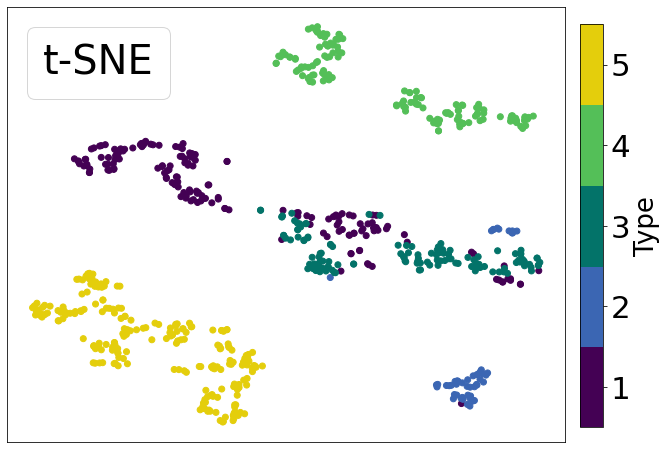

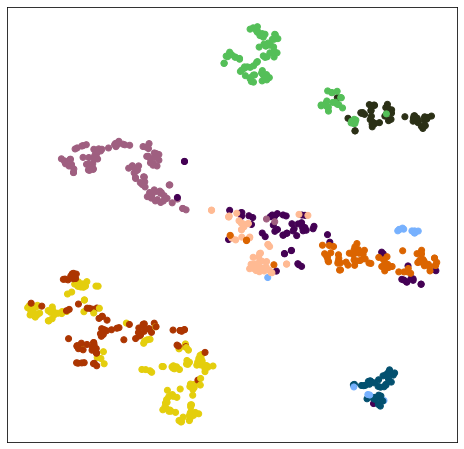

In [77]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red('Type', X_TSNE, Labels[1],'t-SNE')
    plot_dim_red('category', X_TSNE, Labels[2],'t-SNE')

In [78]:
# Triclabendazole and Albendazole (one R ar and one R ali are more similar to aliphatic, not aromatic)
# the purple type 1 in the type 2 cluster is probably gamma-Thiobutyrolactone

Perphenazine: 50


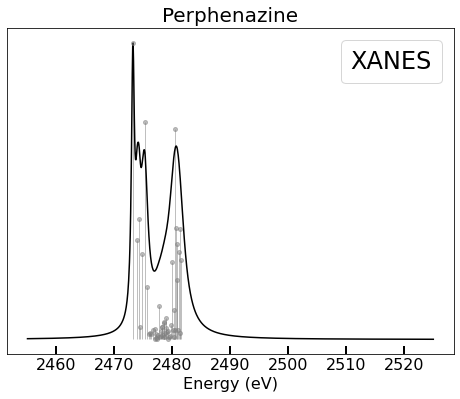

gamma-Thiobutyrolactone: 50


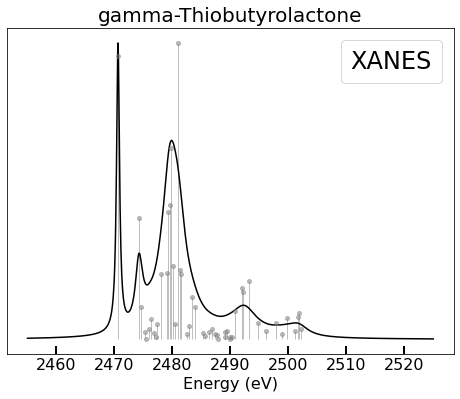

2-2-Hydroxyphenyl_benzothiazole: 100


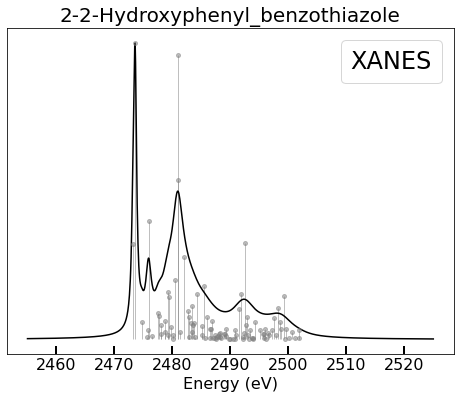

In [79]:
check_these = ['Perphenazine','gamma-Thiobutyrolactone', '2-2-Hydroxyphenyl_benzothiazole']
# check_these = ['Dibenzyl_sulfone',
# 'Dimethyl_sulfone',
# 'Dipropyl_Sulfide-sulfone',
# 'Divinyl_sulfone',
# 'Emtricitabine-sulfone']
for name in check_these:
    index = NAMES.index(name)

    x = get_Spectrum(Data, name, mode='XANES')[1]/SCALING_FACTOR
    trans = Data[index]['Transitions']
    print(f'{name}: {len(trans[0])}')

    plot_spectrum_and_trans(adjust_trans(trans, x), [XANESenergy, x], f'{name}', figsize=(8,6),
                            label='XANES')

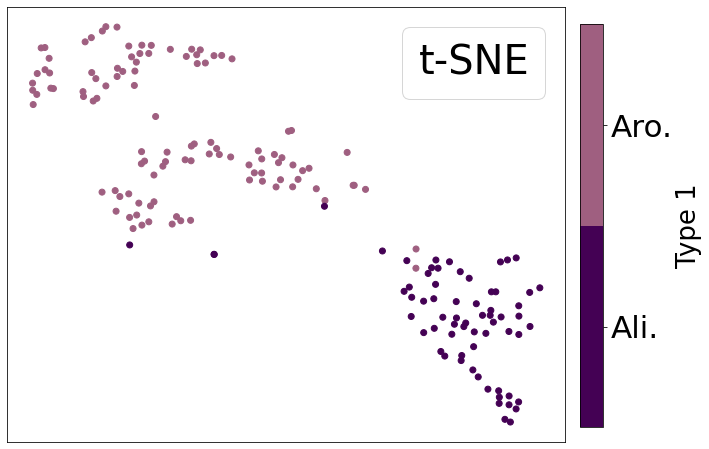

In [80]:
# 'Aliphatic' vs 'Aromatic' per type t-SNE
select_type = 1
x_one = []
y_one = []
names_one = []
for ele in Data:
    if ele['Type'] == select_type:
        x = ele['XANES'][1]
        x = x/SCALING_FACTOR
        x_one.append(x)
        y = ele['conj']
        y_one.append(y)
        names_one.append(ele['name'])

x_one = np.array(x_one)
y_one = np.array(y_one)

tsne = TSNE(n_components=2, perplexity=15, random_state=30)
X_TSNE_one = tsne.fit_transform(x_one)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red(select_type, X_TSNE_one, y_one,'t-SNE')

### The two dark purple aliphatic in the aromatic cluster are gamma-Thiobutyrolactone and Triclabendazole.

gamma-Thiobutyrolactone:
<img src="https://www.sigmaaldrich.com/content/dam/sigma-aldrich/structure7/191/mfcd00005479.eps/_jcr_content/renditions/mfcd00005479-medium.png" alt="drawing" width="100"/>

Triclabendazole:
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Triclabendazole.svg/215px-Triclabendazole.svg.png" alt="drawing" width="250"/>

### The two light purple aromatic in the aliphatic cluster are Perphenazine andTrimeprazine

In [81]:
# bool_arr = y_one == 1
# for i,pt in enumerate(X_TSNE_one):
#     x, y = pt
#     if y < -2.5 and bool_arr[i]:
#         print(names_one[i])

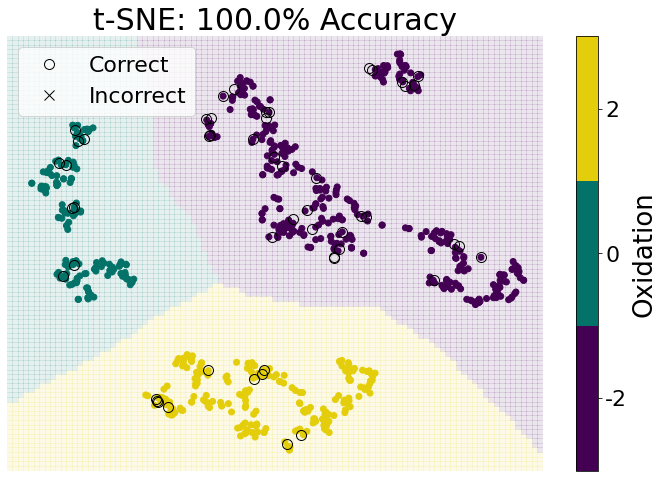

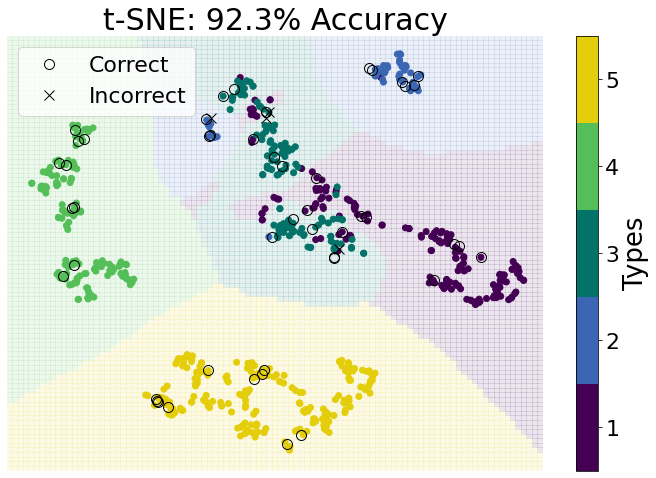

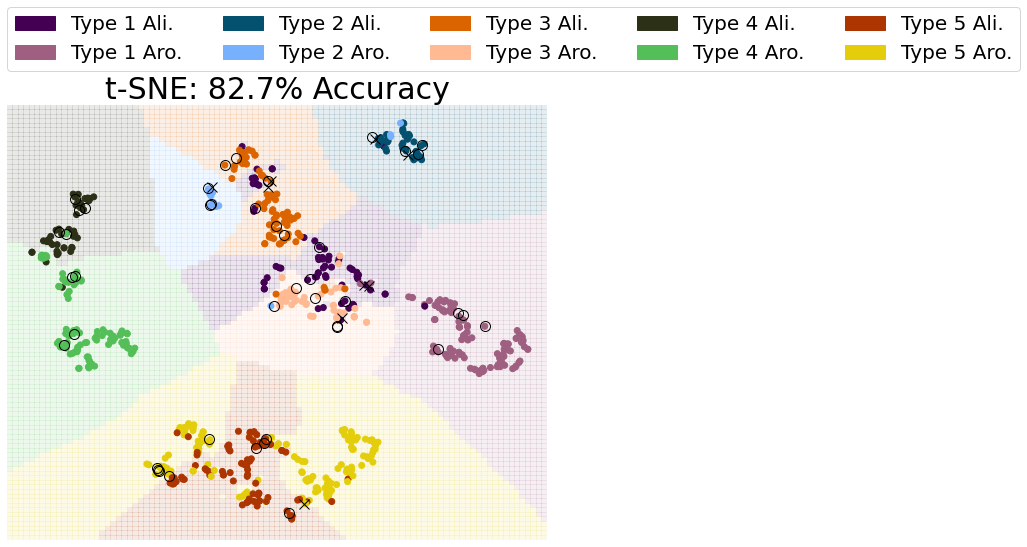

In [82]:
tsne = TSNE(n_components=2, perplexity=15, random_state=30)
everything = list(X)
for x in TEST_XANES:
    everything.append(x)
everything = np.array(everything)
X_TSNE = tsne.fit_transform(everything)
TEST_SIZE = len(TEST_XANES)

i = 0
KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=20)
i = 1
KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=20)
i = 2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=10)

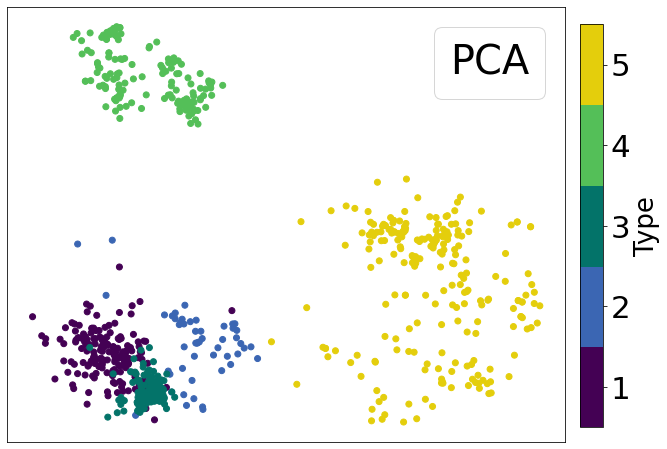

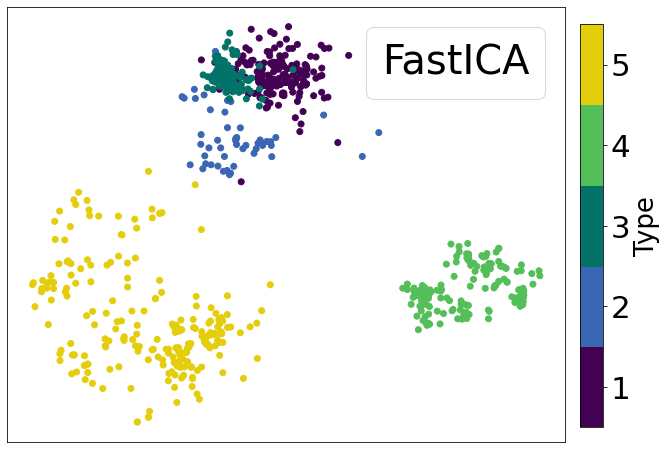

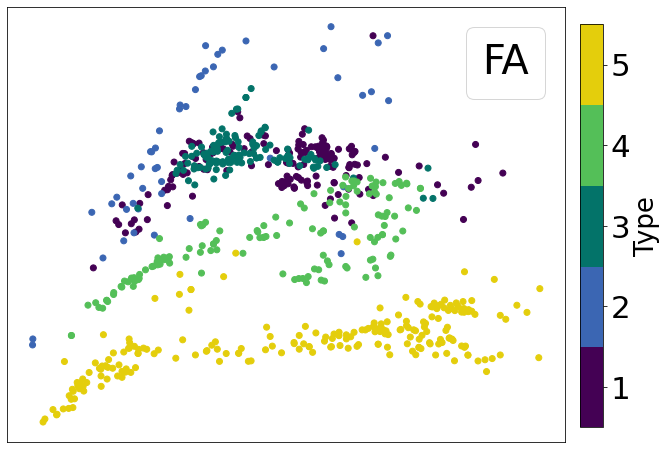

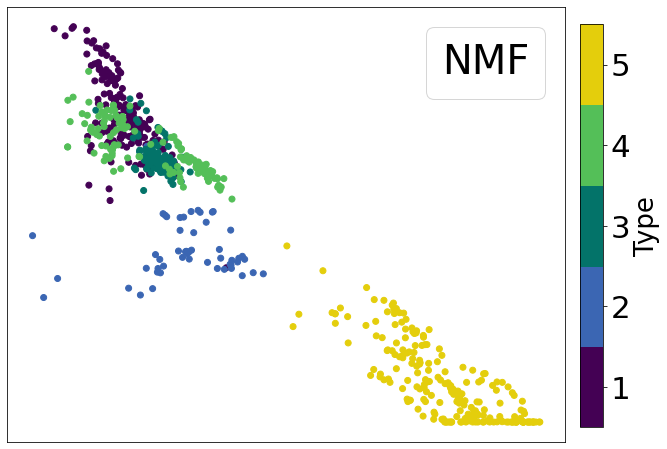

In [83]:
plot_dim_red('Type', X_PCA, Labels[1],'PCA')
plot_dim_red('Type', X_FastICA, Labels[1],'FastICA')
plot_dim_red('Type', X_FA, Labels[1],'FA')
plot_dim_red('Type', X_NMF, Labels[1],'NMF')

In [84]:
fastICA = FastICA(n_components=2)

fa = FactorAnalysis(n_components=2)

nmf = NMF(n_components=2)

pca = PCA(n_components=2)

z_mean = encoder.predict(X)[0]
TEST_z_mean = encoder.predict(TEST_XANES)[0]

In [85]:
Acc = [[],[],[]]
print("Oxidation:")
neis = 20
i = 0
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis, plot=False))
print("\nType:")
neis = 20
i = 1
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis, plot=False))
print("\nAro:")
neis = 10
i = 2
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis, plot=False))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis, plot=False))

Oxidation:
KNN on VAE: Oxidation (Accuracy: 1.00)
KNN on PCA: Oxidation (Accuracy: 1.00)
KNN on FastICA: Oxidation (Accuracy: 1.00)
KNN on FA: Oxidation (Accuracy: 0.87)
KNN on NMF: Oxidation (Accuracy: 0.85)
KNN on t-SNE: Oxidation (Accuracy: 1.00)

Type:
KNN on VAE: Types (Accuracy: 0.87)
KNN on PCA: Types (Accuracy: 0.88)
KNN on FastICA: Types (Accuracy: 0.88)
KNN on FA: Types (Accuracy: 0.62)
KNN on NMF: Types (Accuracy: 0.81)
KNN on t-SNE: Types (Accuracy: 0.92)

Aro:
KNN on VAE: Category (Accuracy: 0.63)
KNN on PCA: Category (Accuracy: 0.73)
KNN on FastICA: Category (Accuracy: 0.73)
KNN on FA: Category (Accuracy: 0.40)
KNN on NMF: Category (Accuracy: 0.54)
KNN on t-SNE: Category (Accuracy: 0.83)


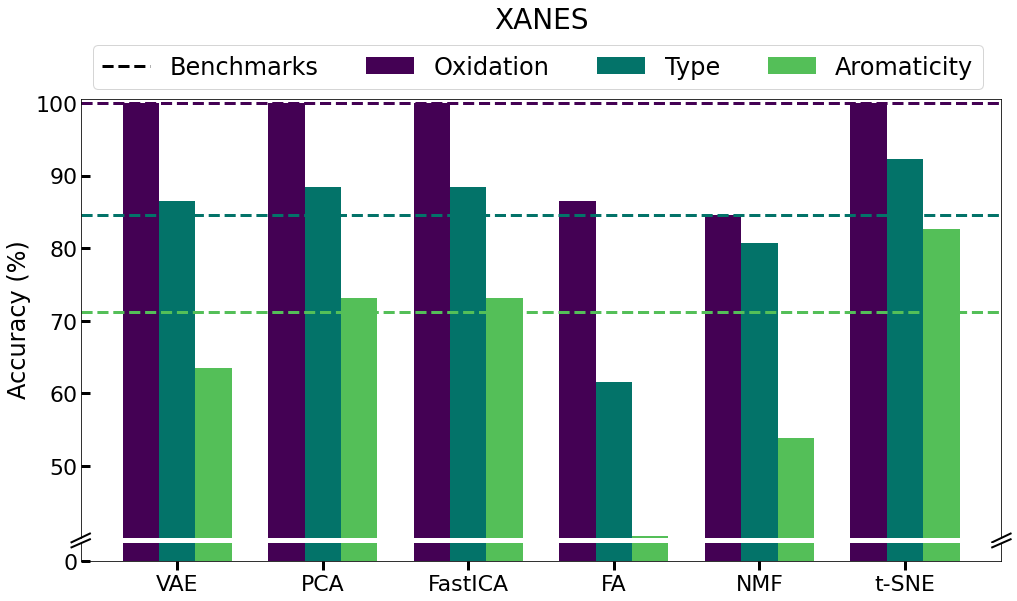

In [133]:
bar_chart(Acc, [100,84.6,71.2], mode='XANES')

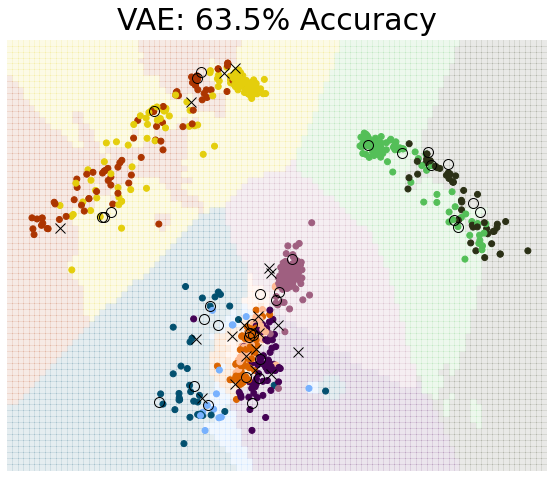

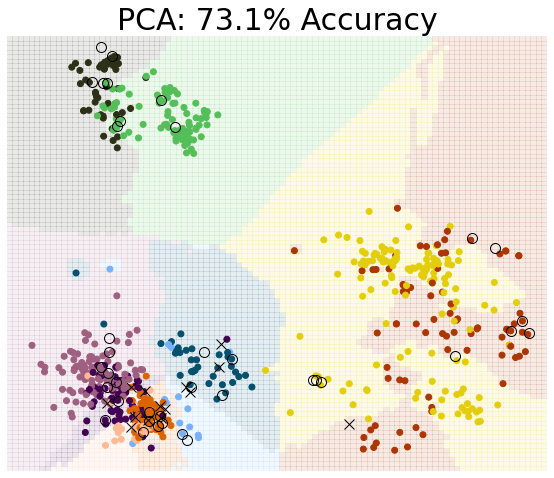

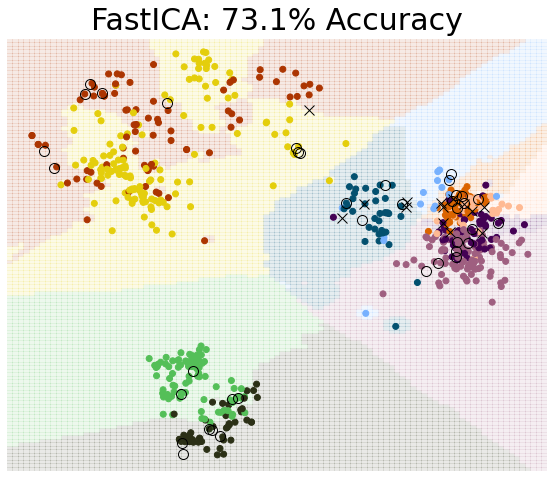

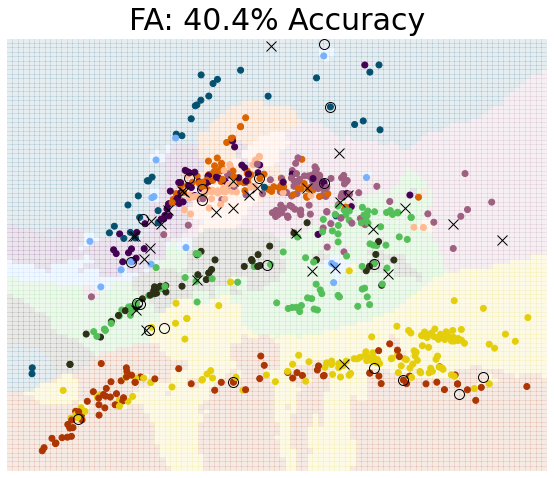

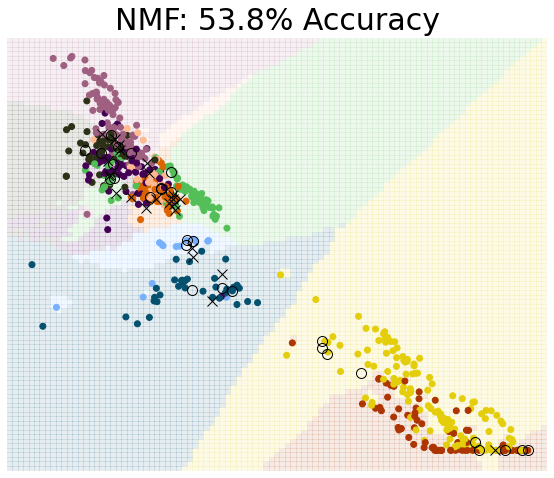

In [87]:
neis = 10
i = 2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    KNN_2D(encoder, Labels[i], 'VAE', scheme=i+1, n_neighbors=neis)
    KNN_2D(pca, Labels[i], 'PCA', scheme=i+1, n_neighbors=neis)
    KNN_2D(fastICA, Labels[i],'FastICA', scheme=i+1, n_neighbors=neis)
    KNN_2D(fa, Labels[i],'FA', scheme=i+1, n_neighbors=neis)
    KNN_2D(nmf, Labels[i],'NMF', scheme=i+1, n_neighbors=neis)